In [248]:
import pymongo
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from wordcloud import WordCloud

from pymongo import MongoClient

%matplotlib inline

# connecting to mongodb

In [3]:
client = MongoClient('localhost:27017')
db = client.arXivDB
db.arXivfeeds.count()

46898

retrieving the available fields as a reference

In [13]:
print(db.arXivfeeds.find_one().keys())

dict_keys(['arxiv_primary_category', 'updated', 'link', 'arxiv_doi', 'author', 'author_detail', 'published_parsed', 'id', 'authors', '_id', 'summary_detail', 'title_detail', 'arxiv_journal_ref', 'published', 'updated_parsed', 'guidislink', 'arxiv_comment', 'links', 'summary', 'tags', 'title'])


In [58]:
for item in db.arXivfeeds.find({'published_parsed': 2016}).sort('_id', pymongo.DESCENDING).limit(5):
    print(item['title'])

Contextuality under weak assumptions
Phase sensing beyond the standard quantum limit with a truncated SU(1,1)
  interferometer
Highly indistinguishable and strongly entangled photons from symmetric
  GaAs quantum dots
Finite-key-size effect in commercial plug-and-play QKD system
The role of phases in detecting three qubit entanglement


In [44]:
#db.arXivfeeds.delete_many({})

## build a field specific stop word list

## function for cleaning text

In [400]:
def cleaner(doc, stem=False):
    '''Function to clean the text data and prep for further analysis'''
    doc = doc.lower() # turn text to lowercase

    stops = set(stopwords.words("english"))       # Creating a set of Stopwords
    p_stemmer = PorterStemmer()                   # Creating the stemmer model

    doc = re.sub(r"quantum", '', doc)           # removing the word quantum (duh)
    doc = re.sub(r"physics", '', doc)           # removing the word physics (duh)
    doc = re.sub(r"state", '', doc)           # removing the word state (duh)
    doc = re.sub(r'\$.*?\$', 'latexinlineformula', doc) # replacing latex inline formula
    doc = re.sub(r'\\n', ' ', doc) # removing new line character
    doc = re.sub(r'\\\\\"', '', doc)             # removing german double dotted letters
    doc = re.sub(r"</?\w+[^>]*>", '', doc)      # removing html tags
    doc = re.sub("[^a-zA-Z]", ' ', doc)    # removing anythin other alpha-numerical char's and @ and !

    doc = doc.split()                          # Splits the data into individual words 
    doc = [w for w in doc if not w in stops and len(w) > 3]   # Removes stopwords and short length words
    if stem:
        doc = [p_stemmer.stem(i) for i in doc]     # Stemming (reducing words to their root)
    if not len(doc):                            # dealing with comments that are all emojis, stop words or other languages
        doc = ['emptystring']
    # print('text cleaning done!')
    return ' '.join(doc)

In [401]:
cleaner(db.arXivfeeds.find_one({'published_parsed': 2016})['summary'])

'landau problem dimensional plane magnetic translation wave induced plane electric field geometric phase accompanying magnetic translation around closed path differs topological phase aharonov bohm essential aspects wave direct contact magnetic flux geometric phase opposite sign aharonov bohm phase show magnetic translation dimensional cylinder implemented schr odinger time evolution truly leads aharonov bohm effect magnetic field normal cylinder surface given line magnetic monopoles simulated cold atom experiments propose extension aharonov bohm experiment demonstrate mutually counteracting effect local magnetic translation geometric phase topological phase aharonov bohm'

## plotting the wordcloud for abstracts and titles from various years

In [167]:
def plot_abstract_and_title_wordcloud(arXivfeed_query_result):
    
    arXivfeed_2015_text = cleaner(' '.join([' '.join(list(d.values())) for d in arXivfeed_query_result]))

    # Generate a word cloud image
    wordcloud_arXivfeed_2015 = WordCloud().generate(arXivfeed_2015_text)

    # Display the generated image:
    plt.imshow(wordcloud_arXivfeed_2015)
    plt.axis("off")

text cleaning done!


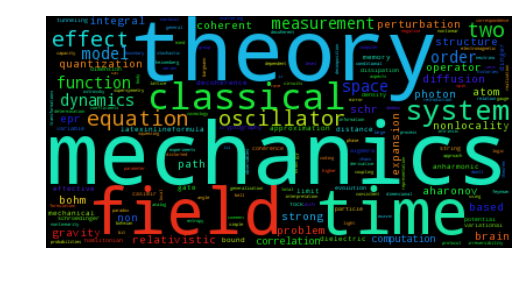

In [173]:
plot_abstract_and_title_wordcloud(list(db.arXivfeeds.find({'published_parsed': 1995}, {'_id':0,'title':1})))

text cleaning done!


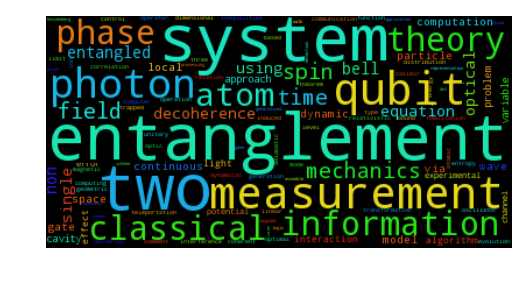

In [174]:
plot_abstract_and_title_wordcloud(list(db.arXivfeeds.find({'published_parsed': 2002}, {'_id':0,'title':1})))

text cleaning done!


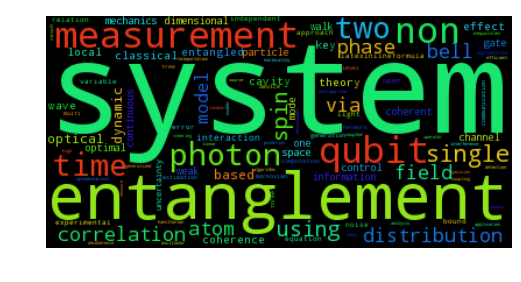

In [175]:
plot_abstract_and_title_wordcloud(list(db.arXivfeeds.find({'published_parsed': 2015}, {'_id':0,'title':1})))

## plotting the number publications per year

In [244]:
years = range(1994,2016,1)

In [117]:
num_publications_per_year = [db.arXivfeeds.find({'published_parsed': y}).count() for y in years]

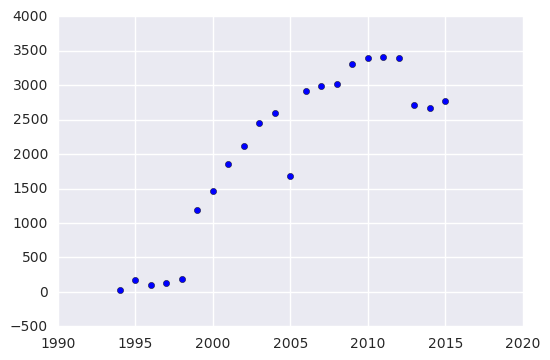

In [245]:
plt.plot(years, num_publications_per_year)

this shows that the database is missing entries and judging from the total number of downloaded items, there must be around 30000 papers missing 

## plotting the relative appearance of a few terms 

In [288]:
pattern1 = r'[Pp]hoton\w*'
pattern2 = r'[Oo]ptic\w*'
set(re.findall(pattern2, 
               ' '.join([' '.join(list(d.values())) for d in db.arXivfeeds.find({}, {'_id':0,'summary':1})])))

{'Optic',
 'Optica',
 'Optical',
 'Optically',
 'Optics',
 'optic',
 'optical',
 'optically',
 'opticallydegenerate',
 'optico',
 'optics'}

In [289]:
num_ph_papers = np.zeros(len(years))
for i, y in enumerate(years):
    num_ph_papers[i] = db.arXivfeeds.find({'$and':[{'published_parsed': y},
                        {'$or':[
                            {'summary': {'$regex': pattern1}},
                            {'title': {'$regex': pattern1}},
                            {'summary': {'$regex': pattern2}},
                            {'title': {'$regex': pattern2}}
                        ]}
                        ]}).count()

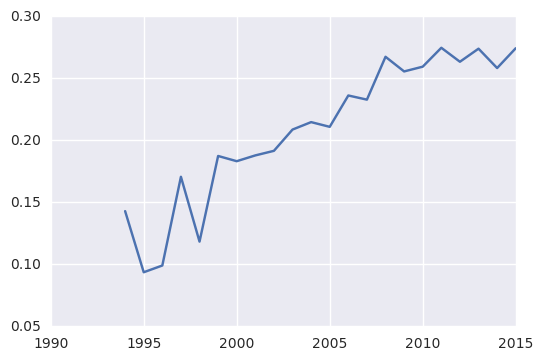

In [290]:
plt.plot(years, num_ph_papers/num_publications_per_year)

## plotting the world map of author affiliations

there is no affiliation in the parsed data

In [309]:
list(db.arXivfeeds.find({'published_parsed': 2016}).limit(1))[0]

{'_id': ObjectId('580e12a55284fc105cae8b47'),
 'arxiv_comment': '12 pages, 1 figure, remarks and two references added about relations\n  with some recent experiments, minor changes and corrections',
 'arxiv_doi': '10.1016/j.aop.2016.06.019',
 'arxiv_journal_ref': 'Ann. Phys. (N.Y.) 373 (2016) 87',
 'arxiv_primary_category': {'scheme': 'http://arxiv.org/schemas/atom',
  'term': 'quant-ph'},
 'author': 'W. Lu',
 'author_detail': {'name': 'W. Lu'},
 'authors': [{'name': 'J. Chee'}, {'name': 'W. Lu'}],
 'guidislink': True,
 'id': 'http://arxiv.org/abs/1601.00046v5',
 'link': 'http://arxiv.org/abs/1601.00046v5',
 'links': [{'href': 'http://dx.doi.org/10.1016/j.aop.2016.06.019',
   'rel': 'related',
   'title': 'doi',
   'type': 'text/html'},
  {'href': 'http://arxiv.org/abs/1601.00046v5',
   'rel': 'alternate',
   'type': 'text/html'},
  {'href': 'http://arxiv.org/pdf/1601.00046v5',
   'rel': 'related',
   'title': 'pdf',
   'type': 'application/pdf'}],
 'published': '2016-01-01T04:26:02Z',

## using LDA to map out the topics

In [410]:
import nltk
import gensim
import pyLDAvis
import pyLDAvis.gensim

In [409]:
documents = [cleaner(d['summary']) for d in db.arXivfeeds.find({'published_parsed': 2010}, {'_id':0, 'summary':1})]
# documents = [cleaner(d['summary']) for d in db.arXivfeeds.find({}, {'_id':0, 'summary':1})]

In [411]:
train_set = []
for j in range(len(documents)):
    train_set.append(nltk.word_tokenize(documents[j]))

In [412]:
dic = gensim.corpora.Dictionary(train_set)
print(len(dic))
dic.filter_extremes(no_below=20, no_above=0.1)
print(len(dic))

11132
1775


In [413]:
corpus = [dic.doc2bow(text) for text in train_set]  # transform every token into BOW

In [414]:
tfidf = gensim.models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]
lda = gensim.models.LdaModel(corpus_tfidf, id2word = dic, num_topics = 10, iterations=20, passes = 10)
corpus_lda = lda[corpus_tfidf]

In [415]:
vis_data = pyLDAvis.gensim.prepare(lda, corpus, dic)
pyLDAvis.display(vis_data)

## using RNN to create a fake abstract